In [58]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.exposure import cumulative_distribution

In [59]:
class HistogramProcessing:
    def __init__(self, input_image):
        self.img = input_image
        self.hist, self.bins = self.histogram()

    def histogram(self):
        '''
        Histogram shape is related to image appearance.
        Images with four basic intensity characteristics: dark, light, low contrast, and high
        contrast; the image histograms are also shown. We note in the dark image that the
        most populated histogram bins are concentrated on the lower (dark) end of the
        intensity scale. Similarly, the most populated bins of the light image are biased
        toward the higher end of the scale. An image with low contrast has a narrow histo


         Intuitively, it is reasonable to conclude
        that an image whose pixels tend to occupy the entire range of possible
         intensity levels and, in addition, tend to be distributed uniformly, will have an appearance of high
        contrast and will exhibit a large variety of gray tones.
        '''
        # hist, bin_edge = np.histogram(self.img.ravel(), bins=256, range=(0, 255))
        hist, bin_edge = np.histogram(self.img.ravel(), bins=256, range=(0, 255))
        return hist, bin_edge

    def histogram_streching(self, Max=255, Min=0):
        min_pixel = np.min(self.img)
        max_pixel = np.max(self.img)
        stretch = ((self.img - min_pixel) / (max_pixel - min_pixel)) * (Max - Min) + Min
        return stretch

    def histogram_clipping(self, minimum_clipping=10, Max=255, Min=0):

        for index, item in enumerate(self.hist):
            if item >= minimum_clipping:
                f_min = index
                break

        for index, item in enumerate(np.flip(self.hist)):
            if item >= minimum_clipping:
                f_max = self.hist.shape[0] - index
                break

        clip = ((self.img - f_min) / (f_max - f_min)) * (Max - Min) + Min

        clip = np.array(clip, dtype='uint8')
        clip = np.where(clip < 0, 255, clip)
        clipped_image = clip
        return clipped_image

    def histogram_normalization(self):
        hist, bin_edge = np.histogram(self.img.ravel(), bins=256, range=(0, 255))
        row, col = self.img.shape
        return hist / (row * col)

    def histogram_equalization(self, L=256):
        hist = self.histogram_normalization()
        # append any remaining 0 values to the histogram
        cdf = (L - 1) * hist.cumsum()
        image_equalized = np.interp(self.img, range(0, 256), cdf)

        image_equalized = np.array(image_equalized, dtype='uint8')
        self.img = image_equalized
        equalaized_hist, _ = self.histogram()

        return image_equalized, equalaized_hist


In [60]:
class HistMatching:
    def __init__(self, input_image, template_image) -> None:
        self.input_image = input_image
        self.template_image = template_image
        self.image_cdf = self._cdf(self.input_image)
        self.template_cdf = self._cdf(self.template_image)

    def _cdf(self, input_image):
        '''
        computes the CDF of an image
        '''
        c, b = cumulative_distribution(input_image)
        # pad the beginning and ending pixels and their CDF values
        c = np.insert(c, 0, [0] * b[0])
        c = np.append(c, [1] * (255 - b[-1]))
        return c

    def hist_matching(self):
        '''
        image_cdf: CDF of input image
        template_cdf: CDF of template
        input_image: input image
        returns the modified pixel values
        '''
        pixels = np.arange(256)
        # find closest pixel-matches corresponding to the CDF of the input image, given the value of the CDF H of
        # the template image at the corresponding pixels, s.t. c_t = H(pixels) <=> pixels = H-1(c_t)
        new_pixels = np.interp(self.image_cdf, self.template_cdf, pixels)
        modified_image = (np.reshape(new_pixels[self.input_image.ravel()], self.input_image.shape)).astype(np.uint8)
        return modified_image

In [61]:
def plot_image(image, title):
    plt.title(title)
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()


def plot(input_data, title):
    plt.title(title)
    plt.plot(input_data)
    plt.show()

In [62]:
img = io.imread("../Images/CameraMan.png")

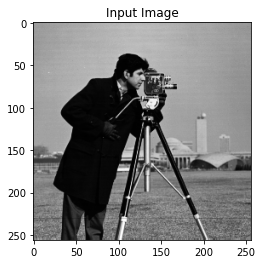

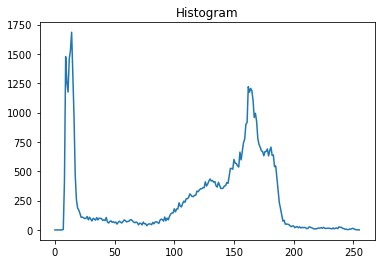

In [63]:
histogram = HistogramProcessing(img)
hist, bins = histogram.histogram()
plot_image(img, "Input Image")
plot(hist, "Histogram")

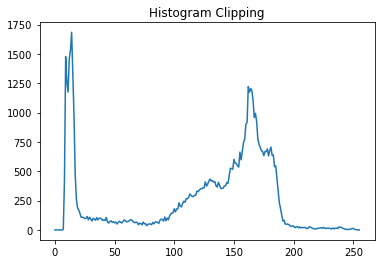

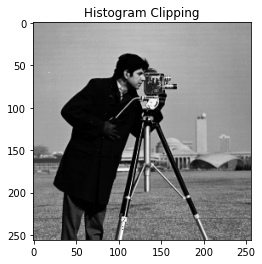

In [64]:
# Histogram Clipping
clipped_image = histogram.histogram_clipping()
plot(hist, "Histogram Clipping")
plot_image(clipped_image, "Histogram Clipping")

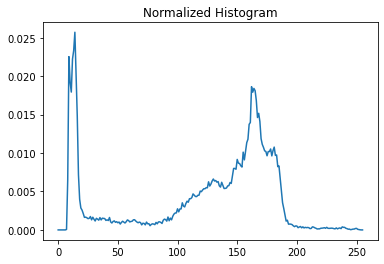

In [65]:
# Histogram Normalization
normal_hist = histogram.histogram_normalization()
plot(normal_hist, 'Normalized Histogram')

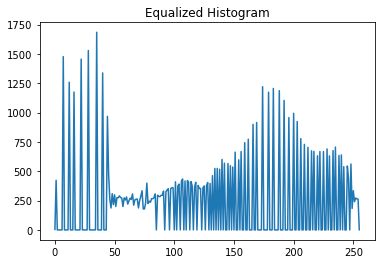

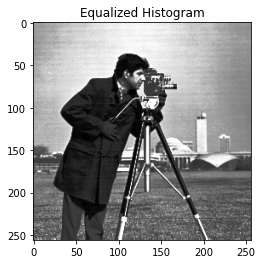

In [66]:
# Histogram Equalization
image_equalized, equalized_hist = histogram.histogram_equalization(256)
plot(equalized_hist, 'Equalized Histogram')
plot_image(image_equalized, 'Equalized Histogram')

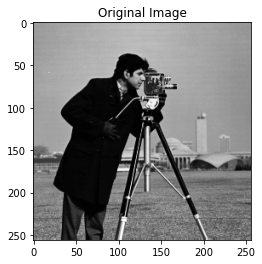

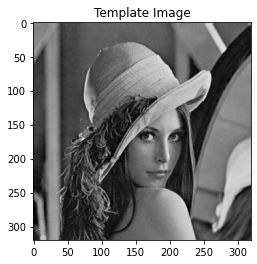

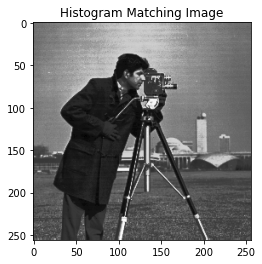

In [67]:
# Histogram Matching
img = io.imread("../Images/CameraMan.png")
template = io.imread("../Images/Hat.jpg")
match_hist = HistMatching(img, template).hist_matching()
plot_image(img, 'Original Image')
plot_image(template, 'Template Image')
plot_image(match_hist, 'Histogram Matching Image')